In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from nltk.corpus import stopwords
import re
from collections import Counter

warnings.filterwarnings("ignore")
color_list = ['#faa5c7', '#eb679c', '#cc3d76', '#b3245d', '#d40457', '#8f1042', '#6e042e']
color_palette = sns.color_palette(color_list)
sns.set_palette(color_palette)
cmap = LinearSegmentedColormap.from_list('custom_palette', color_list, N=256)

X_train (1780,) | X_test (445,) | y_train (1780,) | y_test (445,)


<Axes: >

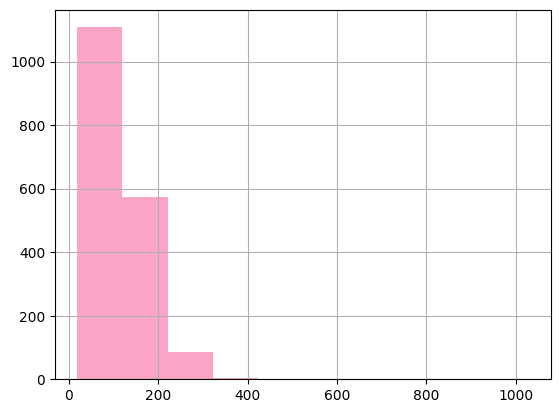

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv('./data/bbc_data.csv')

def string_preprocess(s):
    s = re.sub(r"[^\w\s]", '', s) # 移除除了字母、数字、空格外的字符
    s = re.sub(r"\s+", '', s) # 移除空格
    s = re.sub(r"\d", '', s) # 移除数字

    return s

def get_vocabulary(sentence_list):
    word_list = []
    stop_words = set(stopwords.words('english'))
    for sentence in sentence_list:
        for word in sentence.lower().split():
            processed_word = string_preprocess(word)
            if processed_word not in stop_words and processed_word != '':
                word_list.append(processed_word)

    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    onehot_dict = {word:i+1 for i,word in enumerate(corpus_)}
    
    return onehot_dict

def data_preprocess(data: pd.DataFrame):
    X, y = data.loc[:, 'data'].values, data.loc[:, 'labels'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
    print(f'X_train {X_train.shape} | X_test {X_test.shape} | y_train {y_train.shape} | y_test {y_test.shape}')
    
    vocab = get_vocabulary(X_train)
    
    new_X_train, new_X_test = [], []
    
    for sentence in X_train:
        new_X_train.append([vocab[string_preprocess(word)] for word in sentence.lower().split() if string_preprocess(word) in vocab.keys()])
        
    for sentence in X_test:
        new_X_test.append([vocab[string_preprocess(word)] for word in sentence.lower().split() if string_preprocess(word) in vocab.keys()])
    
    le = LabelEncoder()
    new_y_train = le.fit_transform(y_train)
    new_y_test = le.transform(y_test)
    
    return new_X_train, new_X_test, new_y_train, new_y_test, vocab

X_train, X_test, y_train, y_test, vocab = data_preprocess(data)
rev_len = [len(text) for text in X_train]
pd.Series(rev_len).hist()

In [3]:
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

X_train = padding(X_train, 500)
X_test = padding(X_test, 500)
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, drop_last = True)

In [4]:
class ArticleRNN(nn.Module):
    def __init__(self, num_layers, vocab_size, hidden_dim, embedding_dim, output_dim):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, 
                            num_layers = num_layers, batch_first = True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x =  x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden 

net = ArticleRNN(num_layers=2, hidden_dim=512,
                 output_dim=5, embedding_dim=64, vocab_size=len(vocab)+1)

In [ ]:
class Accumulator:  # 累加多个变量的类
    def __init__(self, n):
        self.data = [0.0]*n

    def add(self, *args):  # 在data的对应位置加上对应的数
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train(net, num_epochs, batch_size, device):

    def get_num_accs(y_hat, y):
        return torch.sum(y_hat.argmax(axis=-1) == y)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
    clip = 5
    net.to(device).train()
    train_acc, train_loss = [], []
    
    for epoch in range(1, num_epochs+1):
        metric = Accumulator(3) # 经过样本数 总损失 总正确数
        h = net.init_hidden(batch_size)

        for X, y in train_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device, dtype=torch.long)
            h = tuple([each.data for each in h])
            y_hat, h = net(X, h)
            loss = loss_function(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            metric.add(X.shape[0], loss.item(), get_num_accs(y_hat, y))
        
        train_acc.append(metric[2] / metric[0])
        train_loss.append(metric[1] / metric[0])
        if epoch % 10 == 0:
            print(f"Epoch {epoch}  |  训练准确率:{train_acc[-1]*100:.2f}%  |  训练损失:{train_loss[-1]:.5f}")
        
    return train_acc, train_loss

train_acc, train_loss = train(net, num_epochs=50, batch_size=batch_size, device=device)

Epoch 10  |  训练准确率:63.74%  |  训练损失:0.06621
Epoch 20  |  训练准确率:98.65%  |  训练损失:0.00307
Epoch 30  |  训练准确率:99.94%  |  训练损失:0.00015
Epoch 40  |  训练准确率:100.00%  |  训练损失:0.00004
Epoch 50  |  训练准确率:100.00%  |  训练损失:0.00001


In [6]:
def test(net, batch_size, device):

    def get_num_accs(y_hat, y):
        return torch.sum(y_hat.argmax(axis=-1) == y).cpu()
    
    net.to(device).eval()
    loss_function = nn.CrossEntropyLoss()
    test_acc, test_loss = [], []
    y_true, y_pred = [], []

    with torch.no_grad():
        h = net.init_hidden(batch_size)
        for idx, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device, dtype=torch.int), y.to(device, dtype=torch.long)
            h = tuple([each.data for each in h])
            y_hat, h = net(X, h)
            y_hat = y_hat.squeeze()
            loss = loss_function(y_hat, y)
            y_true.extend(y)
            y_pred.extend(torch.argmax(y_hat.cpu(), axis = 1))
            test_acc.append(get_num_accs(y_hat, y) / len(y))
            test_loss.append(loss.item())
            print(f"第 {idx} 批测试数据  |  准确率:{test_acc[-1]*100:.2f}%  |  损失:{test_loss[-1]:.5f}")

    return test_acc, test_loss, y_true, y_pred

test_acc, test_loss, y_true, y_pred = test(net, batch_size=batch_size, device=device)

第 0 批测试数据  |  准确率:93.75%  |  损失:0.51219
第 1 批测试数据  |  准确率:81.25%  |  损失:1.29209
第 2 批测试数据  |  准确率:87.50%  |  损失:0.93069
第 3 批测试数据  |  准确率:81.25%  |  损失:0.63979
第 4 批测试数据  |  准确率:100.00%  |  损失:0.00237
第 5 批测试数据  |  准确率:93.75%  |  损失:0.11531
第 6 批测试数据  |  准确率:93.75%  |  损失:0.06761
第 7 批测试数据  |  准确率:81.25%  |  损失:1.56513
第 8 批测试数据  |  准确率:100.00%  |  损失:0.00979
第 9 批测试数据  |  准确率:93.75%  |  损失:0.25244
第 10 批测试数据  |  准确率:93.75%  |  损失:0.18728
第 11 批测试数据  |  准确率:100.00%  |  损失:0.00003
第 12 批测试数据  |  准确率:100.00%  |  损失:0.00055
第 13 批测试数据  |  准确率:87.50%  |  损失:0.65994
第 14 批测试数据  |  准确率:93.75%  |  损失:0.23914
第 15 批测试数据  |  准确率:100.00%  |  损失:0.03594
第 16 批测试数据  |  准确率:100.00%  |  损失:0.01103
第 17 批测试数据  |  准确率:93.75%  |  损失:0.34949
第 18 批测试数据  |  准确率:100.00%  |  损失:0.03145
第 19 批测试数据  |  准确率:93.75%  |  损失:0.70042
第 20 批测试数据  |  准确率:100.00%  |  损失:0.00007
第 21 批测试数据  |  准确率:100.00%  |  损失:0.03654
第 22 批测试数据  |  准确率:100.00%  |  损失:0.00004
第 23 批测试数据  |  准确率:100.00%  |  损失:0.00042
第 24 批测试数据  |  

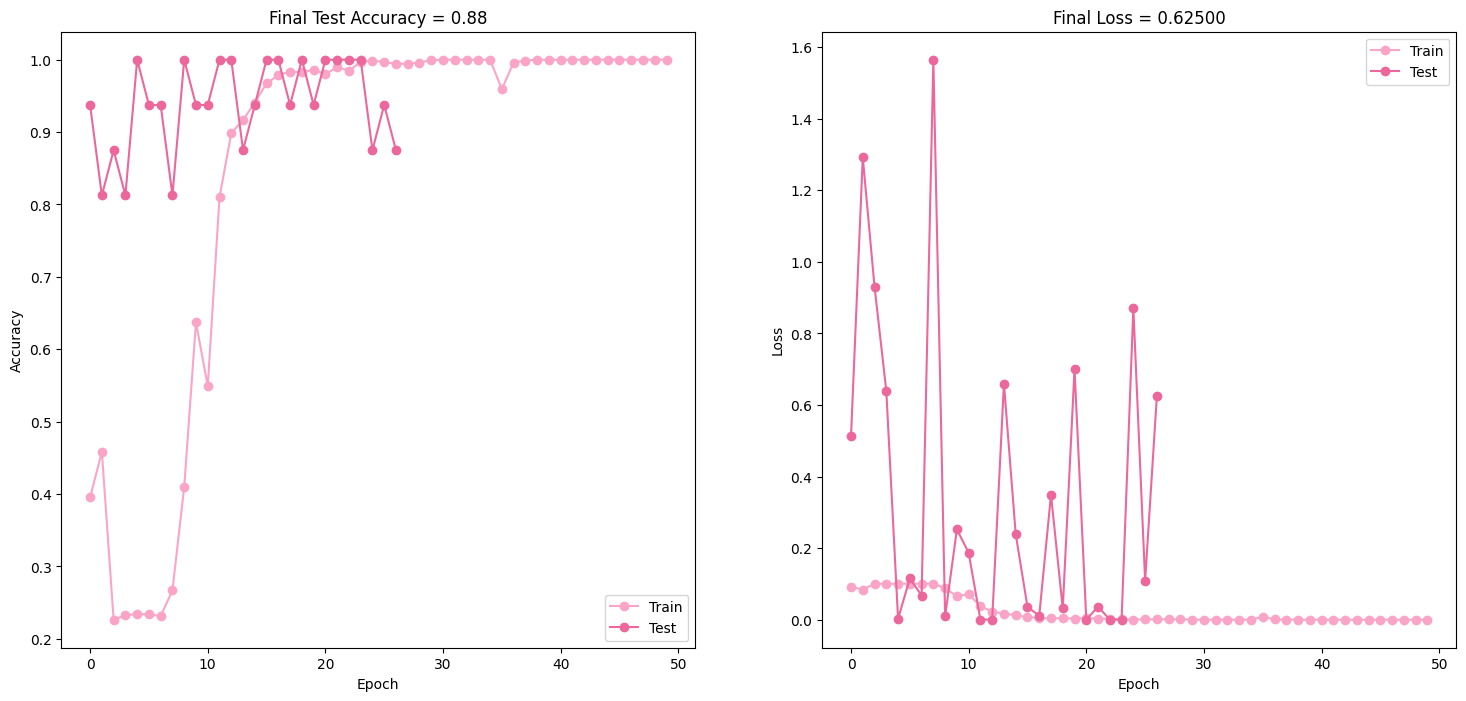

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

axes[0].plot(train_acc, 'o-', label = 'Train')
axes[0].plot(test_acc, 'o-', label = 'Test')
axes[0].set_title(f'Final Test Accuracy = {test_acc[-1]:.2f}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(train_loss, 'o-', label = 'Train')
axes[1].plot(test_loss, 'o-', label = 'Test')
axes[1].set_title(f'Final Loss = {test_loss[-1]:.5f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
plt.show()

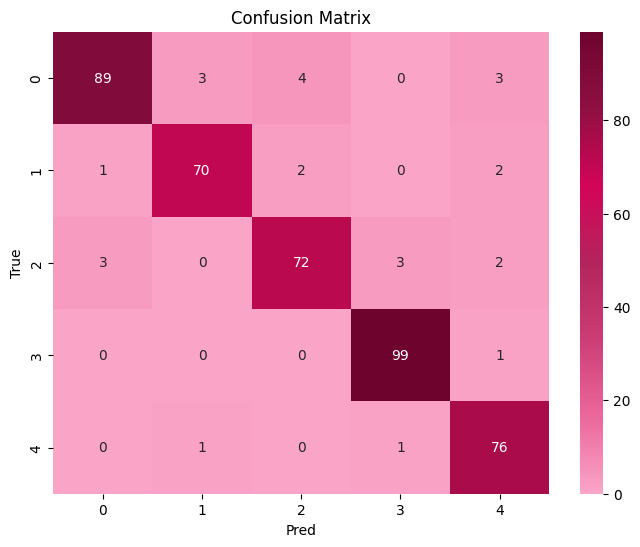

在测试集上的精确率(Precision): 93.98%
在测试集上的召回率(Recall): 93.98%


In [8]:
y_true, y_pred = [y.item() for y in y_true], [y.item() for y in y_pred]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=cmap, fmt='g')
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
precision = precision_score(y_true, y_pred, average = 'micro')
recall = recall_score(y_true, y_pred, average = 'micro')
print(f"在测试集上的精确率(Precision): {precision*100:.2f}%")
print(f"在测试集上的召回率(Recall): {recall*100:.2f}%")